# baseline 1

    설명
    
    1. 데이터셋
    - [X] orgin
    - [O] origin + mol features
    
    2. 전처리
    - [O] stand.
    
    3. lgbm
    - [O] binary classification loss

### import library

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Descriptors
%matplotlib inline

import lightgbm as lgbm

from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import log_loss, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, roc_curve, auc

RDKit WARNING: [19:23:42] Enabling RDKit 2019.09.3 jupyter extensions
/Users/skcc10170/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


### load data

In [176]:
CURRENT_PATH = '/Users/skcc10170/Desktop'

df_train = pd.read_csv(CURRENT_PATH + '/data/org/train_.csv')
df_valid = pd.read_csv(CURRENT_PATH + '/data/org/valid_.csv')
df_test = pd.read_csv(CURRENT_PATH + '/data/org/predict_input.csv')

df_train['type'] = 'train'
df_valid['type'] = 'valid'
df_test['type']  = 'test'

df_tot = pd.concat([df_train, df_valid, df_test], sort=True).reset_index(drop=True)

### feature generating from molecule

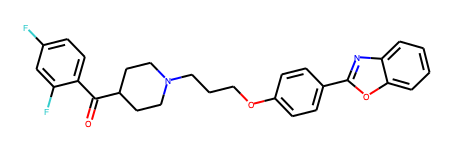

In [3]:
# for test
sample = df_tot['SMILES'][0]
sample = Chem.MolFromSmiles(sample)
sample

In [4]:
df_tot['myf_NumAtoms']            = df_tot.SMILES.apply(lambda x: Chem.MolFromSmiles(x).GetNumAtoms())
df_tot['myf_NumHeavyAtoms']       = df_tot.SMILES.apply(lambda x: Chem.MolFromSmiles(x).GetNumHeavyAtoms())
df_tot['myf_GetNumBonds']         = df_tot.SMILES.apply(lambda x: Chem.MolFromSmiles(x).GetNumBonds())
df_tot['myf_GetNumHeavyBonds']    = df_tot.SMILES.apply(lambda x: Chem.MolFromSmiles(x).GetNumBonds(onlyHeavy=True))

df_tot['myf_ExactMolWt']          = df_tot.SMILES.apply(lambda x: Descriptors.ExactMolWt(Chem.MolFromSmiles(x)))
df_tot['myf_HeavyAtomMolWt']      = df_tot.SMILES.apply(lambda x: Descriptors.HeavyAtomMolWt(Chem.MolFromSmiles(x)))
df_tot['myf_FpDensityMorgan1']    = df_tot.SMILES.apply(lambda x: Descriptors.FpDensityMorgan1(Chem.MolFromSmiles(x)))
df_tot['myf_FpDensityMorgan2']    = df_tot.SMILES.apply(lambda x: Descriptors.FpDensityMorgan2(Chem.MolFromSmiles(x)))
df_tot['myf_FpDensityMorgan3']    = df_tot.SMILES.apply(lambda x: Descriptors.FpDensityMorgan3(Chem.MolFromSmiles(x)))
df_tot['myf_MaxAbsPartialCharge'] = df_tot.SMILES.apply(lambda x: Descriptors.MaxAbsPartialCharge(Chem.MolFromSmiles(x)))
df_tot['myf_MaxPartialCharge']    = df_tot.SMILES.apply(lambda x: Descriptors.MaxPartialCharge(Chem.MolFromSmiles(x)))
df_tot['myf_MinAbsPartialCharge'] = df_tot.SMILES.apply(lambda x: Descriptors.MinAbsPartialCharge(Chem.MolFromSmiles(x)))
df_tot['myf_MinPartialCharge']    = df_tot.SMILES.apply(lambda x: Descriptors.MinPartialCharge(Chem.MolFromSmiles(x)))
df_tot['myf_MolWt']               = df_tot.SMILES.apply(lambda x: Descriptors.MolWt(Chem.MolFromSmiles(x)))
df_tot['myf_NumRadicalElectrons'] = df_tot.SMILES.apply(lambda x: Descriptors.NumRadicalElectrons(Chem.MolFromSmiles(x)))
df_tot['myf_NumValenceElectrons'] = df_tot.SMILES.apply(lambda x: Descriptors.NumValenceElectrons(Chem.MolFromSmiles(x)))

df_tot['myf_NumDoubleBondType'] = df_tot.SMILES.apply(lambda x: len([1 for b in Chem.MolFromSmiles(x).GetBonds() if b.GetBondTypeAsDouble() == 1.0]))

### data feature

In [5]:
# find all columns
cols = df_train.columns

# smiles code
cols_smiles = 'SMILES'

# node-edge level (3 footprints)
cols_ecfp = list(cols[cols.str.contains('ecfp_')]) # ecfp 1024개
cols_fcfp = list(cols[cols.str.contains('fcfp_')]) # fcfp 1024개
cols_ptfp = list(cols[cols.str.contains('ptfp_')]) # ptfp 1024개

# graph level
cols_mol = ['MolWt', 'clogp', 'sa_score', 'qed']

### new features
cols_new_f = list(cols[cols.str.contains('myf_')])

# input cols
cols_input1 = cols_ecfp + cols_fcfp + cols_ptfp # don't have to normalize
cols_input2 = cols_mol + cols_new_f # have to normalize
cols_input  = cols_input1 + cols_input2

# label
cols_label = 'label'

### CV start!

In [6]:
n_splits     = 5
random_state = 2020
random_seed  = 2020
data_random_seed = 2020
feature_fraction_seed = 2020

num_test     = len(df_test) # 927

kfold = StratifiedKFold(n_splits=n_splits, random_state=random_state, shuffle=True)

In [7]:
x_train, y_train = df_train[cols_input].values, df_train[cols_label].values
x_valid, y_valid = df_valid[cols_input].values, df_valid[cols_label].values
x_test            = df_test[cols_input].values

trainset_x = np.vstack([x_train, x_valid])
trainset_y = np.hstack([y_train, y_valid])

In [43]:
params = {
    'objective' :'binary',
    'learning_rate' : 0.019,
    'num_leaves' : 90,
    'feature_fraction': 0.9, 
    'bagging_fraction': 0.8, 
    'bagging_freq':1,
    'boosting_type' : 'dart',
    'metric': {'binary_logloss'},
    'max_depth' : 32
}

In [271]:
val_f1, val_acc, val_loss = [], [], []
results = np.zeros((kfold.n_splits, num_test), dtype=np.float)
prob_results = np.zeros(len(trainset_x), dtype=np.float)

for i, (train_idx, valid_idx) in enumerate(kfold.split(trainset_x, trainset_y)):
    
    # 데이터셋 나눔(train, valid & x,y)
    x_train, y_train = trainset_x[train_idx], trainset_y[train_idx]
    x_valid, y_valid = trainset_x[valid_idx], trainset_y[valid_idx]
    x_test           = df_test[cols_input].values
    
    # 트레인셋 기준으로 평균값, 표준편차 계산
    ## 수치형 변수 기준
    ### baseline : cols_input2(수치형)
    cktpt = len(cols_input2)
    tr_mean, tr_std = x_train[:, -cktpt:].mean(axis=0), x_train[:, -cktpt:].std(axis=0)
    
    # train/valid 
    x_train[:,-cktpt:] = (x_train[:,-cktpt:] - tr_mean) / (tr_std + 1e-5)
    x_valid[:,-cktpt:] = (x_valid[:,-cktpt:] - tr_mean) / (tr_std + 1e-5)
    x_test[:,-cktpt:]  = (x_test[:,-cktpt:]  - tr_mean) / (tr_std + 1e-5)
    
    d_train = lgbm.Dataset(x_train, y_train)
    d_valid = lgbm.Dataset(x_valid, y_valid)
    
    model = lgbm.train(params, d_train, 30000, valid_sets=[d_valid, d_train], valid_names=['val', 'train'],
                       verbose_eval=100, early_stopping_rounds=100)
    
    valid_pred_prob = model.predict(x_valid, num_iteration=model.best_iteration)
    prob_results[valid_idx] = valid_pred_prob
    y_valid_pred = (valid_pred_prob > 0.5).astype(int)
    
    f1 = f1_score(y_valid, y_valid_pred)
    acc = accuracy_score(y_valid, y_valid_pred)
    loss = model.best_score['val']['binary_logloss']
    
    print(f'Fold {i} | Valid Accuracy: {acc}, F1 Score: {f1}')

    results[i] = model.predict(x_test, num_iteration=model.best_iteration)
    val_f1.append(f1)
    val_acc.append(acc)
    val_loss.append(loss)

print(f'Valid Accuracy: {np.mean(val_acc)}, F1 Score: {np.mean(val_f1)}')

Training until validation scores don't improve for 100 rounds.
[100]	train's binary_logloss: 0.497193	val's binary_logloss: 0.545531
[200]	train's binary_logloss: 0.432764	val's binary_logloss: 0.506886
[300]	train's binary_logloss: 0.373272	val's binary_logloss: 0.475363
[400]	train's binary_logloss: 0.327123	val's binary_logloss: 0.453621
[500]	train's binary_logloss: 0.284676	val's binary_logloss: 0.436509
[600]	train's binary_logloss: 0.268116	val's binary_logloss: 0.432103
[700]	train's binary_logloss: 0.241701	val's binary_logloss: 0.42396
[800]	train's binary_logloss: 0.224683	val's binary_logloss: 0.42102
[900]	train's binary_logloss: 0.203339	val's binary_logloss: 0.414825
[1000]	train's binary_logloss: 0.189318	val's binary_logloss: 0.412243
[1100]	train's binary_logloss: 0.174254	val's binary_logloss: 0.410151
[1200]	train's binary_logloss: 0.16538	val's binary_logloss: 0.408913
[1300]	train's binary_logloss: 0.154123	val's binary_logloss: 0.407981
Early stopping, best itera

In [273]:
df_result

,type,SMILES,label,1,predict
0,train,Fc1ccc(C(=O)C2CCN(CCCOc3ccc(cc3)c4oc5ccccc5n4)...,0.0,0.983695,1.0
1,train,CC(C)n1c(CNC2CCCC2)nc(C)c1c3ccc(Cl)cc3,0.0,0.952843,1.0
2,train,COCC1=C([C@@H](c2ccc(Cl)c(Cl)c2)n3nccc3N1)C(=O...,1.0,0.957418,1.0
3,train,CCCCCCCCc1cccc(CCCCCCCC)[n+]1C,0.0,0.955474,1.0
4,train,CC[C@H]1CN([C@H](C)CN1C2CCN(CC2)C(=O)c3ccc(Cl)...,1.0,0.934284,1.0
...,...,...,...,...,...
9271,test,COc1ccc2nccc([C@@H](O)CC[C@@H]3CCN(CCSc4ccc[se...,NaN,NaN,0.0
9272,test,C[C@@]1(CC[C@](C)(C1)c2nc(c3ccc(cc3)C(=O)Nc4cc...,NaN,NaN,0.0
9273,test,Cc1noc(n1)c2cccc(CN3CCN(CC3)C(=O)c4ccc(C[C@@H]...,NaN,NaN,0.0
9274,test,CCN(CC)Cc1cc(\C=N\N=C(/N)\CC(O)c2cc3c(F)cc(F)c...,NaN,NaN,0.0


In [309]:
df_result = df_tot[['type','SMILES','label']]
df_result.loc[:, '1'] = pd.Series(np.hstack([prob_results, results.mean(axis=0)]))
df_result.loc[:, 'predict'] = (df_result['1'] > 0.5).astype(int)
df_result = df_result[['type', 'SMILES', '1', 'label', 'predict']]

In [317]:
OUTPUT_PATH = '/Users/skcc10170/Desktop/data/model_result/'
output_name = 'model_acc_' + "{:.4f}".format(np.mean(val_acc)) \
                           + '_f1_' + "{:.4f}".format(np.mean(val_f1)) \
                           + '_loss_' + "{:.4f}".format(np.mean(val_loss)) \
                           + '.csv'

In [318]:
df_result.to_csv(OUTPUT_PATH + output_name)
print(output_name)

model_acc_0.8062_f1_0.8252_loss_0.4144.csv
